<a href="https://colab.research.google.com/github/nonono-copen/mov2mp4/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/ 'My Drive'/signate/健診データによる肝疾患判定

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/ My Drive/signate/健診データによる肝疾患判定


In [ ]:
# ライブラリのインストール
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
""" 必要なライブラリをimport"""
import argparse
import operator
import os
import time
from   collections import OrderedDict
from   tqdm        import tqdm


import torch
import torch.nn                    as nn
import torch.utils.data            as data
from   torch.utils.data.dataloader import DataLoader
import torchvision
import torchvision.transforms as transforms

import csv
import numpy              as     np
import pandas             as     pd
import seaborn            as     sns   # データの傾向確認用
from   sklearn               import preprocessing
from   sklearn.preprocessing import OrdinalEncoder

from   PIL                import Image
from   pathlib            import Path
from   matplotlib         import pyplot as plt
# %matplotlib inline  # Jupyter Notebookでインライン表示する
from   torch.autograd     import Variable
from   IPython.display    import display
from   torchvision.utils  import save_image # テスト用

In [ ]:
 # 学習用csvデータ確認
 df = pd.read_table('./dataset/train.csv', sep=',')
 df.columns = ['Age', 'Gender', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio', 'disease']
 df.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [ ]:
# ラベルエンコーディング（OrdinalEncoder）
oe      = preprocessing.OrdinalEncoder()
encoded = oe.fit_transform(df[['Gender']].values)

# データフレームを作成
encodered_df = pd.DataFrame(encoded, columns= ['Gender_enc'])
# decoded = oe.inverse_transform(encoded)
# エンコードしたデータに差し替え
df.insert(loc = 2, column= 'Gender_enc', value= encodered_df)
df = df.drop(columns='Gender') # エンコード前のGender列を削除
df.head()

,Age,Gender,Gender_enc,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,1.0,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.0,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,1.0,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,1.0,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,0.0,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [ ]:
df = df.drop(columns='Gender') # エンコード前のGender列を削除
df.head()

,Age,Gender_enc,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,1.0,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,1.0,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,1.0,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,1.0,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,0.0,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


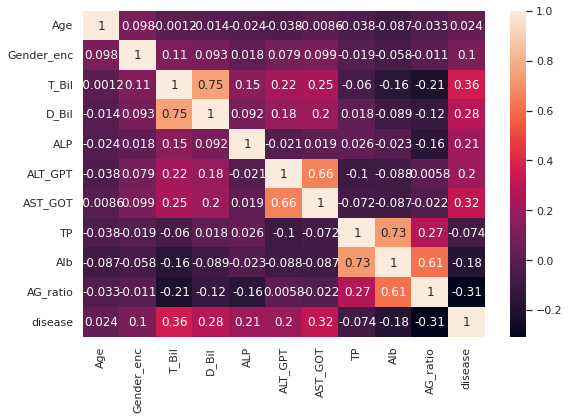

In [ ]:
# データの可視化
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
sns.set(style='darkgrid')

plt.figure(figsize=(9,6))
sns.heatmap(df.corr(), annot=True)

In [ ]:
# Age(0列目)〜AG_ration(10列目)を特徴量として使う
X = df.iloc[:, :10]
X.head()

,Age,Gender_enc,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,59,1.0,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802
1,69,1.0,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346
2,65,1.0,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952
3,65,1.0,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155
4,22,0.0,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654


In [ ]:
# disease(11列目)を特徴量として使う
y = df.iloc[:,10:11]
y.head()

,disease
0,0
1,1
2,0
3,1
4,0


In [ ]:
# 相関の低いカラムを削除
# X = X.drop(columns='Age') 
# X = X.drop(columns='Gender_enc')
X.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,59,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802
1,69,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346
2,65,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952
3,65,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155
4,22,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654


In [ ]:
# 学習データとテストデータを4:1で分離
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)


In [ ]:
# 精度計算
def col_acc(y_pred, y_test):
  total_acc = 0
  for i in range(len(y_pred)):
    if (y_pred[i] >0.5 and y_test[i]==1):
      total_acc = total_acc+1
    elif (y_pred[i] <=0.5 and y_test[i]==0):
      total_acc = total_acc+1
  acc = total_acc/len(y_pred)
  return acc

In [ ]:
# Optunaによるハイパラ探索
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import KFold
import lightgbm as lgb
import numpy as np
import optuna

# パラメータ
FOLD         = 5
NUM_ROUND    = 30000
VERBOSE_EVAL = 10000
SEED         = 42
# categorical_list = ['Gender_enc']

# Optunaを使ったハイパーパラメータ探索
def objective(trial):
    # LightGBMパラメータチューニング
    params = {
        'objective'       : 'binary',
        'boosting_type'   : trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),  # default = gbdt
        'num_leaves'      : trial.suggest_int('num_leaves', 10, 1000),                             # default = 31
        'max_depth'       : -1,                                                                    # default = -1(上限なし)
        'learning_rate   ': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),                  # default = 0.1
        'feature_fraction': 0.8,                                                                   # default = 1.0
        'bagging_freq'    : 1,                                                                     # default = 0
        'random_state'    : 0,                                                                     # default = None
        'metric'          : trial.suggest_categorical('metrics', ['binary_logloss', 'rmse', 'auc']),  # default = 'binary_logloss',
        'seed'            : SEED
    }
    
    valid_scores = []
    valid_acc    = []
    # models       = []
    result_data  = {}

    # kFold交差検定で決定係数を算出し、各セットの平均値を返す
    kf = KFold(n_splits=FOLD, shuffle=True, random_state=42)
    for fold, (train_indices, valid_indices) in enumerate(kf.split(X)):
        X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices] # 指定したindexで学習・評価データを分ける
        y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices] 

        train_data = lgb.Dataset(X_train, y_train) 
        valid_data = lgb.Dataset(X_valid, y_valid)

        model = lgb.train(
            params = params,
            train_set             = train_data,
            valid_sets            = [train_data, valid_data],
            categorical_feature   = categorical_list, # categorical_featureを設定
            num_boost_round       = NUM_ROUND,
            early_stopping_rounds = 5,
            verbose_eval          = VERBOSE_EVAL,
            evals_result          = result_data
        )

        y_valid_pred = model.predict(X_valid)
        acc          = col_acc(y_pred=y_valid_pred, y_test=y_valid.to_numpy().squeeze())
        valid_acc.append(acc)

    cv_acc   = np.mean(valid_acc)
    print('CV Accuracy: {}'.format(cv_acc))
    return cv_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-09-28 17:33:04,829] A new study created in memory with name: no-name-3dc98caf-87a5-4cbe-b860-878649feea83
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[10000]	training's auc: 1	valid_1's auc: 0.96048
[20000]	training's auc: 1	valid_1's auc: 0.950286
[30000]	training's auc: 1	valid_1's auc: 0.939394
[10000]	training's auc: 1	valid_1's auc: 0.944149
[20000]	training's auc: 1	valid_1's auc: 0.93995
[30000]	training's auc: 1	valid_1's auc: 0.93561
[10000]	training's auc: 1	valid_1's auc: 0.912
[20000]	training's auc: 1	valid_1's auc: 0.897571
[30000]	training's auc: 1	valid_1's auc: 0.892571
[10000]	training's auc: 1	valid_1's auc: 0.95
[20000]	training's auc: 1	valid_1's auc: 0.946667
[30000]	training's auc: 1	valid_1's auc: 0.937639
[10000]	training's auc: 1	valid_1's auc: 0.936842
[20000]	training's auc: 1	valid_1's auc: 0.930667
[30000]	training's auc: 1	valid_1's auc: 0.929404


[I 2022-09-28 17:41:59,333] Trial 0 finished with value: 0.8447058823529412 and parameters: {'boosting_type': 'dart', 'num_leaves': 432, 'learning_rate': 0.00012137532031618813, 'metrics': 'auc'}. Best is trial 0 with value: 0.8447058823529412.


CV Accuracy: 0.8447058823529412
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[18]	training's auc: 0.987031	valid_1's auc: 0.970814
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.973028	valid_1's auc: 0.941419
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 17:41:59,707] Trial 1 finished with value: 0.8623529411764705 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 403, 'learning_rate': 2.7989899368324844e-08, 'metrics': 'auc'}. Best is trial 1 with value: 0.8623529411764705.


Early stopping, best iteration is:
[53]	training's auc: 1	valid_1's auc: 0.933429
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[33]	training's auc: 0.997294	valid_1's auc: 0.944583
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[14]	training's auc: 0.985678	valid_1's auc: 0.924491
CV Accuracy: 0.8623529411764705
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[18]	training's auc: 0.987031	valid_1's auc: 0.970814
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.973028	valid_1's auc: 0.941419
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[53]	training's auc: 1	valid_1's auc: 0.933429


[I 2022-09-28 17:42:00,111] Trial 2 finished with value: 0.8623529411764705 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 492, 'learning_rate': 8.574513077004163e-06, 'metrics': 'auc'}. Best is trial 1 with value: 0.8623529411764705.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[33]	training's auc: 0.997294	valid_1's auc: 0.944583
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[14]	training's auc: 0.985678	valid_1's auc: 0.924491
CV Accuracy: 0.8623529411764705
[10000]	training's rmse: 1.64468e-05	valid_1's rmse: 0.345962
[20000]	training's rmse: 1.33943e-05	valid_1's rmse: 0.363681
[30000]	training's rmse: 1.32571e-05	valid_1's rmse: 0.370297
[10000]	training's rmse: 1.62569e-05	valid_1's rmse: 0.325069
[20000]	training's rmse: 1.33838e-05	valid_1's rmse: 0.313566
[30000]	training's rmse: 1.30807e-05	valid_1's rmse: 0.327292
[10000]	training's rmse: 1.58901e-05	valid_1's rmse: 0.390777
[20000]	training's rmse: 1.34455e-05	valid_1's rmse: 0.420894
[30000]	training's rmse: 1.29568e-05	valid_1's rmse: 0.432442
[10000]	training's rmse: 1.60479e-05	valid_1's rmse: 0.322211
[20000]	training's rmse: 1.32317e-05	valid_1's r

[I 2022-09-28 17:50:01,633] Trial 3 finished with value: 0.8447058823529412 and parameters: {'boosting_type': 'dart', 'num_leaves': 445, 'learning_rate': 3.6658781972651983e-07, 'metrics': 'rmse'}. Best is trial 1 with value: 0.8623529411764705.


CV Accuracy: 0.8447058823529412
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 17:50:02,090] Trial 4 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'learning_rate': 0.011395709751916889, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0950491	valid_1's binary_logloss: 0.249261
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.119626	valid_1's binary_logloss: 0.298327
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.101339	valid_1's binary_logloss: 0.351179
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 17:50:02,665] Trial 5 finished with value: 0.8658823529411764 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 654, 'learning_rate': 9.337983491373269e-05, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0633748	valid_1's binary_logloss: 0.291879
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.119211	valid_1's binary_logloss: 0.318757
CV Accuracy: 0.8658823529411764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[29]	training's rmse: 0.202664	valid_1's rmse: 0.278989
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 17:50:02,936] Trial 6 finished with value: 0.8670588235294117 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'learning_rate': 9.589570100419882e-08, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[33]	training's rmse: 0.186629	valid_1's rmse: 0.313992
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[55]	training's rmse: 0.106984	valid_1's rmse: 0.328257
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[48]	training's rmse: 0.135916	valid_1's rmse: 0.296164
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[25]	training's rmse: 0.213388	valid_1's rmse: 0.328506
CV Accuracy: 0.8670588235294117
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.195751	valid_1's binary_logloss: 0.259764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.119822	valid_1's binary_logloss: 0.274184
Training until validation scores don't improve for 5 rounds.
Early stopping,

[I 2022-09-28 17:50:03,540] Trial 7 finished with value: 0.8670588235294119 and parameters: {'boosting_type': 'goss', 'num_leaves': 964, 'learning_rate': 0.0542124895205434, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.16957	valid_1's binary_logloss: 0.305775
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.174768	valid_1's binary_logloss: 0.32985
CV Accuracy: 0.8670588235294119
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.195751	valid_1's binary_logloss: 0.259764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.119822	valid_1's binary_logloss: 0.274184
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.164262	valid_1's binary_logloss: 0.382694
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 17:50:04,004] Trial 8 finished with value: 0.8670588235294119 and parameters: {'boosting_type': 'goss', 'num_leaves': 316, 'learning_rate': 0.05098056084660112, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.16957	valid_1's binary_logloss: 0.305775
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.174768	valid_1's binary_logloss: 0.32985
CV Accuracy: 0.8670588235294119
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0950491	valid_1's binary_logloss: 0.249261
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.119626	valid_1's binary_logloss: 0.298327
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.101339	valid_1's binary_logloss: 0.351179
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0633748	valid_1's binary_logloss: 0.2918

[I 2022-09-28 17:50:04,586] Trial 9 finished with value: 0.8658823529411764 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 756, 'learning_rate': 0.09757889903363487, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.



[10000]	training's rmse: 1.66611e-05	valid_1's rmse: 0.348437
[20000]	training's rmse: 1.34197e-05	valid_1's rmse: 0.361596
[30000]	training's rmse: 1.31827e-05	valid_1's rmse: 0.370001
[10000]	training's rmse: 1.63116e-05	valid_1's rmse: 0.32856
[20000]	training's rmse: 1.334e-05	valid_1's rmse: 0.317839
[30000]	training's rmse: 1.31901e-05	valid_1's rmse: 0.334845
[10000]	training's rmse: 1.5701e-05	valid_1's rmse: 0.388841
[20000]	training's rmse: 1.34328e-05	valid_1's rmse: 0.41506
[30000]	training's rmse: 1.28316e-05	valid_1's rmse: 0.425044
[10000]	training's rmse: 1.59269e-05	valid_1's rmse: 0.321975
[20000]	training's rmse: 1.31802e-05	valid_1's rmse: 0.329638
[30000]	training's rmse: 1.30364e-05	valid_1's rmse: 0.333342
[10000]	training's rmse: 1.62981e-05	valid_1's rmse: 0.371233
[20000]	training's rmse: 1.30343e-05	valid_1's rmse: 0.388345
[30000]	training's rmse: 1.26388e-05	valid_1's rmse: 0.398518


[I 2022-09-28 17:57:46,792] Trial 10 finished with value: 0.8482352941176471 and parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'learning_rate': 0.0010221111977549474, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


CV Accuracy: 0.8482352941176471
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.195751	valid_1's binary_logloss: 0.259764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.119822	valid_1's binary_logloss: 0.274184
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.164262	valid_1's binary_logloss: 0.382694
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 17:57:47,382] Trial 11 finished with value: 0.8670588235294119 and parameters: {'boosting_type': 'goss', 'num_leaves': 994, 'learning_rate': 0.7461319032155574, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.16957	valid_1's binary_logloss: 0.305775
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.174768	valid_1's binary_logloss: 0.32985
CV Accuracy: 0.8670588235294119
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's rmse: 0.233621	valid_1's rmse: 0.279653
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[32]	training's rmse: 0.247861	valid_1's rmse: 0.314936
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[54]	training's rmse: 0.205553	valid_1's rmse: 0.342989


[I 2022-09-28 17:57:47,844] Trial 12 finished with value: 0.8611764705882354 and parameters: {'boosting_type': 'goss', 'num_leaves': 983, 'learning_rate': 0.006931596280383355, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[34]	training's rmse: 0.238421	valid_1's rmse: 0.312463
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[45]	training's rmse: 0.220642	valid_1's rmse: 0.325424
CV Accuracy: 0.8611764705882354
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.195751	valid_1's binary_logloss: 0.259764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.119822	valid_1's binary_logloss: 0.274184
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 17:57:48,364] Trial 13 finished with value: 0.8670588235294119 and parameters: {'boosting_type': 'goss', 'num_leaves': 178, 'learning_rate': 0.008119219058882616, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[54]	training's binary_logloss: 0.164262	valid_1's binary_logloss: 0.382694
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.16957	valid_1's binary_logloss: 0.305775
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.174768	valid_1's binary_logloss: 0.32985
CV Accuracy: 0.8670588235294119
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's rmse: 0.233621	valid_1's rmse: 0.279653
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[32]	training's rmse: 0.247861	valid_1's rmse: 0.314936
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 17:57:48,816] Trial 14 finished with value: 0.8611764705882354 and parameters: {'boosting_type': 'goss', 'num_leaves': 738, 'learning_rate': 0.42096022094806734, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[54]	training's rmse: 0.205553	valid_1's rmse: 0.342989
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[34]	training's rmse: 0.238421	valid_1's rmse: 0.312463
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[45]	training's rmse: 0.220642	valid_1's rmse: 0.325424
CV Accuracy: 0.8611764705882354
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0950491	valid_1's binary_logloss: 0.249261
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.119626	valid_1's binary_logloss: 0.298327
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.101339	valid_1's binary_logloss: 0.351179
Training until validation scores don't improve for 5 rou

[I 2022-09-28 17:57:49,397] Trial 15 finished with value: 0.8658823529411764 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'learning_rate': 0.004578433952011531, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0633748	valid_1's binary_logloss: 0.291879
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.119211	valid_1's binary_logloss: 0.318757
CV Accuracy: 0.8658823529411764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's rmse: 0.233621	valid_1's rmse: 0.279653
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[32]	training's rmse: 0.247861	valid_1's rmse: 0.314936
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[54]	training's rmse: 0.205553	valid_1's rmse: 0.342989
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 17:57:49,831] Trial 16 finished with value: 0.8611764705882354 and parameters: {'boosting_type': 'goss', 'num_leaves': 615, 'learning_rate': 0.0005113482994885188, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[34]	training's rmse: 0.238421	valid_1's rmse: 0.312463
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[45]	training's rmse: 0.220642	valid_1's rmse: 0.325424
CV Accuracy: 0.8611764705882354
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's rmse: 0.233621	valid_1's rmse: 0.279653
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[32]	training's rmse: 0.247861	valid_1's rmse: 0.314936
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[54]	training's rmse: 0.205553	valid_1's rmse: 0.342989
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 17:57:50,248] Trial 17 finished with value: 0.8611764705882354 and parameters: {'boosting_type': 'goss', 'num_leaves': 282, 'learning_rate': 0.04980768020707345, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[34]	training's rmse: 0.238421	valid_1's rmse: 0.312463
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[45]	training's rmse: 0.220642	valid_1's rmse: 0.325424
CV Accuracy: 0.8611764705882354
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0950491	valid_1's binary_logloss: 0.249261
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.119626	valid_1's binary_logloss: 0.298327
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.101339	valid_1's binary_logloss: 0.351179
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 17:57:50,774] Trial 18 finished with value: 0.8658823529411764 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'learning_rate': 7.977053469709507e-06, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0633748	valid_1's binary_logloss: 0.291879
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.119211	valid_1's binary_logloss: 0.318757
CV Accuracy: 0.8658823529411764
[10000]	training's auc: 1	valid_1's auc: 0.96048
[20000]	training's auc: 1	valid_1's auc: 0.950286
[30000]	training's auc: 1	valid_1's auc: 0.939394
[10000]	training's auc: 1	valid_1's auc: 0.944149
[20000]	training's auc: 1	valid_1's auc: 0.93995
[30000]	training's auc: 1	valid_1's auc: 0.93561
[10000]	training's auc: 1	valid_1's auc: 0.912
[20000]	training's auc: 1	valid_1's auc: 0.897571
[30000]	training's auc: 1	valid_1's auc: 0.892571
[10000]	training's auc: 1	valid_1's auc: 0.95
[20000]	training's auc: 1	valid_1's auc: 0.946667
[30000]	training's auc: 1	valid_1's auc: 0.937639
[10000]	training's auc: 1	valid_1's auc: 0.936842
[20000]	training's auc: 1	valid_1's auc: 0.9

[I 2022-09-28 18:05:49,805] Trial 19 finished with value: 0.8447058823529412 and parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'learning_rate': 0.005537955309556196, 'metrics': 'auc'}. Best is trial 4 with value: 0.8694117647058823.


CV Accuracy: 0.8447058823529412
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's rmse: 0.233621	valid_1's rmse: 0.279653
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[32]	training's rmse: 0.247861	valid_1's rmse: 0.314936
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[54]	training's rmse: 0.205553	valid_1's rmse: 0.342989
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[34]	training's rmse: 0.238421	valid_1's rmse: 0.312463
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:05:50,200] Trial 20 finished with value: 0.8611764705882354 and parameters: {'boosting_type': 'goss', 'num_leaves': 347, 'learning_rate': 0.17464766157728856, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[45]	training's rmse: 0.220642	valid_1's rmse: 0.325424
CV Accuracy: 0.8611764705882354
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.195751	valid_1's binary_logloss: 0.259764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.119822	valid_1's binary_logloss: 0.274184
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.164262	valid_1's binary_logloss: 0.382694
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.16957	valid_1's binary_logloss: 0.305775


[I 2022-09-28 18:05:50,718] Trial 21 finished with value: 0.8670588235294119 and parameters: {'boosting_type': 'goss', 'num_leaves': 818, 'learning_rate': 0.05676565630866211, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.174768	valid_1's binary_logloss: 0.32985
CV Accuracy: 0.8670588235294119
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.195751	valid_1's binary_logloss: 0.259764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.119822	valid_1's binary_logloss: 0.274184
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.164262	valid_1's binary_logloss: 0.382694
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.16957	valid_1's binary_logloss: 0.305775
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:05:51,222] Trial 22 finished with value: 0.8670588235294119 and parameters: {'boosting_type': 'goss', 'num_leaves': 114, 'learning_rate': 0.01216778633893855, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.174768	valid_1's binary_logloss: 0.32985
CV Accuracy: 0.8670588235294119
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.195751	valid_1's binary_logloss: 0.259764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.119822	valid_1's binary_logloss: 0.274184
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.164262	valid_1's binary_logloss: 0.382694
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.16957	valid_1's binary_logloss: 0.305775


[I 2022-09-28 18:05:51,729] Trial 23 finished with value: 0.8670588235294119 and parameters: {'boosting_type': 'goss', 'num_leaves': 559, 'learning_rate': 0.7375864342396663, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.174768	valid_1's binary_logloss: 0.32985
CV Accuracy: 0.8670588235294119
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.195751	valid_1's binary_logloss: 0.259764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.119822	valid_1's binary_logloss: 0.274184
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.164262	valid_1's binary_logloss: 0.382694
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.16957	valid_1's binary_logloss: 0.305775
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[51]	training

[I 2022-09-28 18:05:52,316] Trial 24 finished with value: 0.8670588235294119 and parameters: {'boosting_type': 'goss', 'num_leaves': 897, 'learning_rate': 0.8111939287582235, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


CV Accuracy: 0.8670588235294119
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0950491	valid_1's binary_logloss: 0.249261
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.119626	valid_1's binary_logloss: 0.298327
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.101339	valid_1's binary_logloss: 0.351179
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:05:52,904] Trial 25 finished with value: 0.8658823529411764 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'learning_rate': 0.0005170445260662047, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0633748	valid_1's binary_logloss: 0.291879
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.119211	valid_1's binary_logloss: 0.318757
CV Accuracy: 0.8658823529411764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.195751	valid_1's binary_logloss: 0.259764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.119822	valid_1's binary_logloss: 0.274184
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.164262	valid_1's binary_logloss: 0.382694
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.16957	valid_1's binary_logloss: 0.305

[I 2022-09-28 18:05:53,483] Trial 26 finished with value: 0.8670588235294119 and parameters: {'boosting_type': 'goss', 'num_leaves': 835, 'learning_rate': 0.02065792505617157, 'metrics': 'binary_logloss'}. Best is trial 4 with value: 0.8694117647058823.


CV Accuracy: 0.8670588235294119
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:05:53,990] Trial 27 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'learning_rate': 0.0010592011945674616, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:05:54,470] Trial 28 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'learning_rate': 0.001770689631133531, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:05:54,937] Trial 29 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'learning_rate': 8.38515795737508e-05, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:05:55,477] Trial 30 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'learning_rate': 4.063181740056907e-05, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:05:55,971] Trial 31 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'learning_rate': 1.5881284168863604e-05, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:05:56,470] Trial 32 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'learning_rate': 1.3892932355857548e-05, 'metrics': 'rmse'}. Best is trial 4 with value: 0.8694117647058823.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[31]	training's rmse: 0.222205	valid_1's rmse: 0.279168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[28]	training's rmse: 0.233796	valid_1's rmse: 0.30929


[I 2022-09-28 18:05:56,739] Trial 33 finished with value: 0.8729411764705881 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'learning_rate': 1.2015569006237162e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[53]	training's rmse: 0.152287	valid_1's rmse: 0.327004
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[45]	training's rmse: 0.181564	valid_1's rmse: 0.30287
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.193094	valid_1's rmse: 0.321695
CV Accuracy: 0.8729411764705881
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 roun

[I 2022-09-28 18:05:57,316] Trial 34 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 399, 'learning_rate': 4.2505462509911235e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[18]	training's auc: 0.987031	valid_1's auc: 0.970814
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.973028	valid_1's auc: 0.941419
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:05:57,684] Trial 35 finished with value: 0.8623529411764705 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 422, 'learning_rate': 1.1162523550972217e-06, 'metrics': 'auc'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[53]	training's auc: 1	valid_1's auc: 0.933429
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[33]	training's auc: 0.997294	valid_1's auc: 0.944583
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[14]	training's auc: 0.985678	valid_1's auc: 0.924491
CV Accuracy: 0.8623529411764705
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[29]	training's rmse: 0.202835	valid_1's rmse: 0.279091
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[29]	training's rmse: 0.20471	valid_1's rmse: 0.314232
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.152857	valid_1's rmse: 0.328747
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[37]	training's rmse: 0.16588	valid

[I 2022-09-28 18:05:57,977] Trial 36 finished with value: 0.8576470588235294 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'learning_rate': 0.001968934934906831, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[29]	training's rmse: 0.195908	valid_1's rmse: 0.330974
CV Accuracy: 0.8576470588235294
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925


[I 2022-09-28 18:05:58,464] Trial 37 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'learning_rate': 2.7089914563308007e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
[10000]	training's auc: 1	valid_1's auc: 0.96048
[20000]	training's auc: 1	valid_1's auc: 0.950286
[30000]	training's auc: 1	valid_1's auc: 0.939394
[10000]	training's auc: 1	valid_1's auc: 0.944149
[20000]	training's auc: 1	valid_1's auc: 0.93995
[30000]	training's auc: 1	valid_1's auc: 0.93561
[10000]	training's auc: 1	valid_1's auc: 0.912
[20000]	training's auc: 1	valid_1's auc: 0.897571
[30000]	training's auc: 1	valid_1's auc: 0.892571
[10000]	training's auc: 1	valid_1's auc: 0.95
[20000]	training's auc: 1	valid_1's auc: 0.946667
[30000]	training's auc: 1	valid_1's auc: 0.937639
[10000]	training's auc: 1	valid_1's auc: 0.936842
[20000]	training's auc: 1	valid_1's auc: 0.930667
[30000]	training's auc: 1	valid_1's auc: 0.929404


[I 2022-09-28 18:14:05,913] Trial 38 finished with value: 0.8447058823529412 and parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'learning_rate': 0.00017174461779414883, 'metrics': 'auc'}. Best is trial 33 with value: 0.8729411764705881.


CV Accuracy: 0.8447058823529412
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[29]	training's rmse: 0.202835	valid_1's rmse: 0.279091
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[29]	training's rmse: 0.20471	valid_1's rmse: 0.314232
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:14:06,245] Trial 39 finished with value: 0.8576470588235294 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'learning_rate': 0.0014961336959678747, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.152857	valid_1's rmse: 0.328747
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[37]	training's rmse: 0.16588	valid_1's rmse: 0.304119
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[29]	training's rmse: 0.195908	valid_1's rmse: 0.330974
CV Accuracy: 0.8576470588235294
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 

[I 2022-09-28 18:14:06,768] Trial 40 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'learning_rate': 2.566441207724999e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925


[I 2022-09-28 18:14:07,283] Trial 41 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'learning_rate': 3.420010201942139e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:14:07,822] Trial 42 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'learning_rate': 1.8941650196829034e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:14:08,340] Trial 43 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'learning_rate': 3.0946147147486293e-07, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:14:08,836] Trial 44 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'learning_rate': 1.455482346677944e-08, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:14:09,337] Trial 45 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'learning_rate': 2.6525641270741446e-08, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:14:09,862] Trial 46 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 287, 'learning_rate': 0.00014548077478013547, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
[10000]	training's rmse: 1.64468e-05	valid_1's rmse: 0.345962
[20000]	training's rmse: 1.33943e-05	valid_1's rmse: 0.363681
[30000]	training's rmse: 1.32571e-05	valid_1's rmse: 0.370297
[10000]	training's rmse: 1.62569e-05	valid_1's rmse: 0.325069
[20000]	training's rmse: 1.33838e-05	valid_1's rmse: 0.313566
[30000]	training's rmse: 1.30807e-05	valid_1's rmse: 0.327292
[10000]	training's rmse: 1.58901e-05	valid_1's rmse: 0.390777
[20000]	training's rmse: 1.34455e-05	valid_1's rmse: 0.420894
[30000]	training's rmse: 1.29568e-05	valid_1's rmse: 0.432442
[10000]	training's rmse: 1.60479e-05	valid_1's rmse: 0.322211
[20000]	training's rmse: 1.32317e-05	valid_1's rmse: 0.325571
[30000]	training's rmse: 1.28376e-05	valid_1

[I 2022-09-28 18:22:16,405] Trial 47 finished with value: 0.8447058823529412 and parameters: {'boosting_type': 'dart', 'num_leaves': 293, 'learning_rate': 0.00019552746977553244, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


CV Accuracy: 0.8447058823529412
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[18]	training's auc: 0.987031	valid_1's auc: 0.970814
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.973028	valid_1's auc: 0.941419
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:22:16,813] Trial 48 finished with value: 0.8623529411764705 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 356, 'learning_rate': 5.797595923986708e-07, 'metrics': 'auc'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[53]	training's auc: 1	valid_1's auc: 0.933429
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[33]	training's auc: 0.997294	valid_1's auc: 0.944583
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[14]	training's auc: 0.985678	valid_1's auc: 0.924491
CV Accuracy: 0.8623529411764705
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	va

[I 2022-09-28 18:22:17,339] Trial 49 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'learning_rate': 6.810488439501912e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:22:17,923] Trial 50 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 482, 'learning_rate': 0.0004799000930513252, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:22:18,429] Trial 51 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'learning_rate': 5.9633780689429196e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:22:18,992] Trial 52 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 512, 'learning_rate': 0.0004494537390155483, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:22:19,539] Trial 53 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 572, 'learning_rate': 0.00032556529621688207, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:22:20,128] Trial 54 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 617, 'learning_rate': 0.0010732774311274357, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925


[I 2022-09-28 18:22:20,630] Trial 55 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'learning_rate': 1.3854256094673937e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
[10000]	training's rmse: 1.65329e-05	valid_1's rmse: 0.351063
[20000]	training's rmse: 1.37436e-05	valid_1's rmse: 0.35584
[30000]	training's rmse: 1.29617e-05	valid_1's rmse: 0.366356
[10000]	training's rmse: 1.60443e-05	valid_1's rmse: 0.322586
[20000]	training's rmse: 1.36426e-05	valid_1's rmse: 0.311542
[30000]	training's rmse: 1.26403e-05	valid_1's rmse: 0.329039
[10000]	training's rmse: 1.61505e-05	valid_1's rmse: 0.393397
[20000]	training's rmse: 1.3537e-05	valid_1's rmse: 0.422348
[30000]	training's rmse: 1.25864e-05	valid_1's rmse: 0.429268
[10000]	training's rmse: 1.59703e-05	valid_1's rmse: 0.316942
[20000]	training's rmse: 1.38603e-05	valid_1's rmse: 0.329865
[30000]	training's rmse: 1.24089e-05	valid_1's rmse: 0.330239
[10000]	training's rmse: 1.60812e-05	valid_1's rmse: 0.369809
[20000]	traini

[I 2022-09-28 18:29:34,983] Trial 56 finished with value: 0.8494117647058823 and parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'learning_rate': 9.993570926981195e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


CV Accuracy: 0.8494117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:29:35,524] Trial 57 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'learning_rate': 2.353119711430182e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:29:36,024] Trial 58 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'learning_rate': 4.027699869140861e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[18]	training's auc: 0.987031	valid_1's auc: 0.970814
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.973028	valid_1's auc: 0.941419
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[53]	training's auc: 1	valid_1's auc: 0.933429
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[33]	training's auc: 0.997294	valid_1's auc: 0.944583


[I 2022-09-28 18:29:36,405] Trial 59 finished with value: 0.8623529411764705 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'learning_rate': 1.896001859179901e-05, 'metrics': 'auc'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[14]	training's auc: 0.985678	valid_1's auc: 0.924491
CV Accuracy: 0.8623529411764705
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925


[I 2022-09-28 18:29:36,920] Trial 60 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'learning_rate': 1.3352811208827877e-07, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:29:37,483] Trial 61 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 263, 'learning_rate': 5.632127249314836e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:29:37,988] Trial 62 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'learning_rate': 1.668116175664682e-07, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:29:38,562] Trial 63 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 385, 'learning_rate': 5.848314542393325e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088


[I 2022-09-28 18:29:39,070] Trial 64 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'learning_rate': 4.275853581367149e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rou

[I 2022-09-28 18:29:39,646] Trial 65 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 316, 'learning_rate': 4.216576419522683e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
[10000]	training's rmse: 1.64468e-05	valid_1's rmse: 0.345962
[20000]	training's rmse: 1.33943e-05	valid_1's rmse: 0.363681
[30000]	training's rmse: 1.32571e-05	valid_1's rmse: 0.370297
[10000]	training's rmse: 1.62569e-05	valid_1's rmse: 0.325069
[20000]	training's rmse: 1.33838e-05	valid_1's rmse: 0.313566
[30000]	training's rmse: 1.30807e-05	valid_1's rmse: 0.327292
[10000]	training's rmse: 1.58901e-05	valid_1's rmse: 0.390777
[20000]	training's rmse: 1.34455e-05	valid_1's rmse: 0.420894
[30000]	training's rmse: 1.29568e-05	valid_1's rmse: 0.432442
[10000]	training's rmse: 1.60479e-05	valid_1's rmse: 0.322211
[20000]	training's rmse: 1.32317e-05	valid_1's rmse: 0.325571
[30000]	training's rmse: 1.28376e-05	valid_1's rmse: 0.329546
[10000]	training's rmse: 1.6072e-05	valid_1's rmse: 0.37463
[20000]	training's rmse: 1.29975e-05	valid_1's rmse: 0.387513
[30000]	train

[I 2022-09-28 18:37:37,262] Trial 66 finished with value: 0.8447058823529412 and parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'learning_rate': 1.5627224184545404e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


CV Accuracy: 0.8447058823529412
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925


[I 2022-09-28 18:37:37,766] Trial 67 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 346, 'learning_rate': 3.0900351770150146e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:37:38,304] Trial 68 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 258, 'learning_rate': 2.3951566697503544e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088


[I 2022-09-28 18:37:38,841] Trial 69 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 362, 'learning_rate': 3.01611435633797e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[18]	training's auc: 0.987031	valid_1's auc: 0.970814
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.973028	valid_1's auc: 0.941419
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[53]	training's auc: 1	valid_1's auc: 0.933429


[I 2022-09-28 18:37:39,237] Trial 70 finished with value: 0.8623529411764705 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'learning_rate': 3.0347967358199823e-05, 'metrics': 'auc'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[33]	training's auc: 0.997294	valid_1's auc: 0.944583
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[14]	training's auc: 0.985678	valid_1's auc: 0.924491
CV Accuracy: 0.8623529411764705
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:37:39,735] Trial 71 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'learning_rate': 0.0031727100924264754, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:37:40,281] Trial 72 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'learning_rate': 9.311897422085148e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:37:40,804] Trial 73 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 322, 'learning_rate': 9.273426806226423e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:37:41,335] Trial 74 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 424, 'learning_rate': 8.20805018724499e-07, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:37:41,809] Trial 75 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'learning_rate': 1.5899164291849435e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:37:42,325] Trial 76 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'learning_rate': 1.3560919276864713e-08, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:37:42,779] Trial 77 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'learning_rate': 5.418624140042716e-08, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
[10000]	training's rmse: 1.64468e-05	valid_1's rmse: 0.345962
[20000]	training's rmse: 1.33943e-05	valid_1's rmse: 0.363681
[30000]	training's rmse: 1.32571e-05	valid_1's rmse: 0.370297
[10000]	training's rmse: 1.62569e-05	valid_1's rmse: 0.325069
[20000]	training's rmse: 1.33838e-05	valid_1's rmse: 0.313566
[30000]	training's rmse: 1.30807e-05	valid_1's rmse: 0.327292
[10000]	training's rmse: 1.58901e-05	valid_1's rmse: 0.390777
[20000]	training's rmse: 1.34455e-05	valid_1's rmse: 0.420894
[30000]	training's rmse: 1.29568e-05	valid_1's rmse: 0.432442
[10000]	training's rmse: 1.60479e-05	valid_1's rmse: 0.322211
[20000]	training's rmse: 1.32317e-05	valid_1's rmse: 0.325571
[30000]	training's rmse: 1.28376e-05	valid_1

[I 2022-09-28 18:45:38,597] Trial 78 finished with value: 0.8447058823529412 and parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'learning_rate': 5.6083933841274066e-08, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


CV Accuracy: 0.8447058823529412
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.241902	valid_1's rmse: 0.276163
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.184629	valid_1's rmse: 0.303988
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[34]	training's rmse: 0.184256	valid_1's rmse: 0.337087
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:38,839] Trial 79 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'learning_rate': 6.037750813952462e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[33]	training's rmse: 0.196455	valid_1's rmse: 0.300567
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[35]	training's rmse: 0.18349	valid_1's rmse: 0.322786
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:39,408] Trial 80 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 428, 'learning_rate': 6.267128492896539e-07, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse:

[I 2022-09-28 18:45:39,950] Trial 81 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 469, 'learning_rate': 0.0003087794112793953, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:40,533] Trial 82 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 569, 'learning_rate': 0.0006081089852253566, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:41,149] Trial 83 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 718, 'learning_rate': 0.00030263806917275025, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925

[I 2022-09-28 18:45:41,694] Trial 84 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 524, 'learning_rate': 5.900396672889907e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.



Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:42,288] Trial 85 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 624, 'learning_rate': 1.4711694618016821e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:42,863] Trial 86 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 666, 'learning_rate': 0.0007616595143050226, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0950491	valid_1's binary_logloss: 0.249261
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.119626	valid_1's binary_logloss: 0.298327
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.101339	valid_1's binary_logloss: 0.351179
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0633748	valid_1's binary_logloss: 0.291879
Training until validation scores don

[I 2022-09-28 18:45:43,471] Trial 87 finished with value: 0.8658823529411764 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 550, 'learning_rate': 2.806571224044278e-07, 'metrics': 'binary_logloss'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.119211	valid_1's binary_logloss: 0.318757
CV Accuracy: 0.8658823529411764
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[10]	training's auc: 0.979365	valid_1's auc: 0.963413
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.973028	valid_1's auc: 0.941419
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[10]	training's auc: 0.982243	valid_1's auc: 0.895429


[I 2022-09-28 18:45:43,741] Trial 88 finished with value: 0.8470588235294118 and parameters: {'boosting_type': 'goss', 'num_leaves': 330, 'learning_rate': 3.5173109496734848e-06, 'metrics': 'auc'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[10]	training's auc: 0.983248	valid_1's auc: 0.932361
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[10]	training's auc: 0.983113	valid_1's auc: 0.917684
CV Accuracy: 0.8470588235294118
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:44,339] Trial 89 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 483, 'learning_rate': 0.0003382428871577195, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:44,849] Trial 90 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'learning_rate': 2.0628047745075626e-07, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:45,389] Trial 91 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'learning_rate': 1.1882887952872854e-07, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:45,905] Trial 92 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'learning_rate': 3.45188608799141e-08, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:46,457] Trial 93 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 278, 'learning_rate': 5.837055138733777e-06, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925


[I 2022-09-28 18:45:46,973] Trial 94 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'learning_rate': 4.4402441753192565e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:47,561] Trial 95 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 588, 'learning_rate': 1.378077032452817e-07, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:48,113] Trial 96 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 605, 'learning_rate': 1.7961944958225934e-07, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 0.235164	valid_1's rmse: 0.283599
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's rmse: 0.162495	valid_1's rmse: 0.309168
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[43]	training's rmse: 0.140618	valid_1's rmse: 0.329088
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:45:48,686] Trial 97 finished with value: 0.8694117647058823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 651, 'learning_rate': 7.00460984640473e-05, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[69]	training's rmse: 0.0738259	valid_1's rmse: 0.293925
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.160351	valid_1's rmse: 0.3212
CV Accuracy: 0.8694117647058823
[10000]	training's rmse: 1.64468e-05	valid_1's rmse: 0.345962
[20000]	training's rmse: 1.33943e-05	valid_1's rmse: 0.363681
[30000]	training's rmse: 1.32571e-05	valid_1's rmse: 0.370297
[10000]	training's rmse: 1.62569e-05	valid_1's rmse: 0.325069
[20000]	training's rmse: 1.33838e-05	valid_1's rmse: 0.313566
[30000]	training's rmse: 1.30807e-05	valid_1's rmse: 0.327292
[10000]	training's rmse: 1.58901e-05	valid_1's rmse: 0.390777
[20000]	training's rmse: 1.34455e-05	valid_1's rmse: 0.420894
[30000]	training's rmse: 1.29568e-05	valid_1's rmse: 0.432442
[10000]	training's rmse: 1.60479e-05	valid_1's rmse: 0.322211
[20000]	training's rmse: 1.32317e-05	valid_1's rmse: 0.325571
[30000]	training's rmse: 1.28376e-05	valid_1

[I 2022-09-28 18:53:44,254] Trial 98 finished with value: 0.8447058823529412 and parameters: {'boosting_type': 'dart', 'num_leaves': 450, 'learning_rate': 0.0001397923553564817, 'metrics': 'rmse'}. Best is trial 33 with value: 0.8729411764705881.


CV Accuracy: 0.8447058823529412
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0950491	valid_1's binary_logloss: 0.249261
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.119626	valid_1's binary_logloss: 0.298327
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.101339	valid_1's binary_logloss: 0.351179
Training until validation scores don't improve for 5 rounds.


[I 2022-09-28 18:53:44,789] Trial 99 finished with value: 0.8658823529411764 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'learning_rate': 5.414875551688183e-06, 'metrics': 'binary_logloss'}. Best is trial 33 with value: 0.8729411764705881.


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0633748	valid_1's binary_logloss: 0.291879
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.119211	valid_1's binary_logloss: 0.318757
CV Accuracy: 0.8658823529411764


In [ ]:
print(study.best_params)
print(study.best_value)

{'boosting_type': 'gbdt', 'num_leaves': 12, 'learning_rate': 1.2015569006237162e-05, 'metrics': 'rmse'}
0.8729411764705881


In [ ]:
# Optunaで探索したベストハイパラでLightGBMを再学習
params = {
    'objective'       : 'binary',
    'boosting_type'   : study.best_params['boosting_type'], # Optunaで探索した値を指定
    'num_leaves'      : study.best_params['num_leaves'],    # Optunaで探索した値を指定
    'max_depth'       : -1,                                 # default = -1(上限なし)
    'learning_rate   ': study.best_params['learning_rate'], # Optunaで探索した値を指定
    'feature_fraction': 0.8,                                # default = 1.0
    'bagging_freq'    : 1,                                  # default = 0
    'random_state'    : 0,                                  # default = None
    'metric'          : study.best_params['metrics'],       # Optunaで探索した値を指定
    'seed'            : SEED
}

valid_scores = []
valid_acc    = []
models       = []
result_data  = {}

# kFold交差検定で決定係数を算出し、各セットの平均値を返す
kf = KFold(n_splits=FOLD, shuffle=True, random_state=42)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices] # 指定したindexで学習・評価データを分ける
    y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices] 

    train_data = lgb.Dataset(X_train, y_train) 
    valid_data = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params = params,
        train_set             = train_data,
        valid_sets            = [train_data, valid_data],
        categorical_feature   = categorical_list, # categorical_featureを設定
        num_boost_round       = NUM_ROUND,
        early_stopping_rounds = 5,
        verbose_eval          = VERBOSE_EVAL,
        evals_result          = result_data
    )

    y_valid_pred = model.predict(X_valid)
    acc          = col_acc(y_pred=y_valid_pred, y_test=y_valid.to_numpy().squeeze())
    print('fold {} accuracy:{}'.format(fold, acc))
    valid_acc.append(acc)
    models.append(model)
cv_acc   = np.mean(valid_acc)
print('CV Accuracy: {}'.format(cv_acc))

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[31]	training's rmse: 0.222205	valid_1's rmse: 0.279168
fold 0 accuracy:0.9
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[28]	training's rmse: 0.233796	valid_1's rmse: 0.30929
fold 1 accuracy:0.8588235294117647
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[53]	training's rmse: 0.152287	valid_1's rmse: 0.327004
fold 2 accuracy:0.8705882352941177
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[45]	training's rmse: 0.181564	valid_1's rmse: 0.30287
fold 3 accuracy:0.8823529411764706
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[39]	training's rmse: 0.193094	valid_1's rmse: 0.321695
fold 4 accuracy:0.8529411764705882
CV Accuracy: 0.8729411764705881


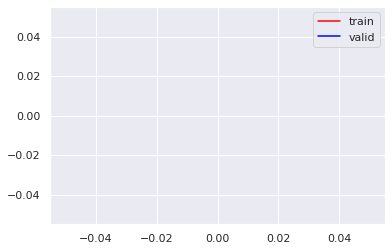

In [ ]:
# 最後のモデルだけ学習過程を表示
import matplotlib.pyplot as plt
plt.plot(result_data["training"]["binary_logloss"], color = "red", label = "train")
plt.plot(result_data["valid_1"]["binary_logloss"], color = "blue", label = "valid")
plt.legend()
plt.show()

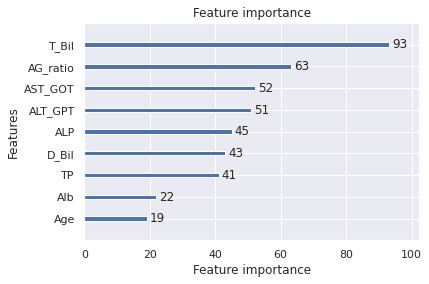

In [ ]:
import matplotlib

# 特徴量の重要度を表示
lgb.plot_importance(model) # 最後のモデルデータのみ表示

In [ ]:
# アンサンブルで予測
y_preds = []
for model in models:
  y_pred = model.predict(X_valid)
  y_preds.append(y_pred)

prediction = np.mean(y_preds, axis=0)
acc = col_acc(y_pred=prediction, y_test=y_valid.to_numpy().squeeze())
print('accuracy:{}'.format(acc))

accuracy:0.9529411764705882


アップロード用データ作成

In [ ]:
# 評価用 test_csvデータ確認
testdata_df = pd.read_table('./dataset/test.csv', sep=',')
testdata_df.columns = ['Age', 'Gender', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']
# ラベルエンコーディング（OrdinalEncoder）
# oe      = preprocessing.OrdinalEncoder()
testdata_encoded = oe.fit_transform(testdata_df[['Gender']].values)

# データフレームを作成
encodered_testdata_df = pd.DataFrame(testdata_encoded, columns= ['Gender_enc'])
# decoded = oe.inverse_transform(encoded)
# エンコードしたデータに差し替え
testdata_df.insert(loc = 2, column= 'Gender_enc', value= encodered_testdata_df)
testdata_df = testdata_df.drop(columns='Gender') # エンコード前のGender列を削除

# 相関の低いカラムを削除 (Age, Gender_enc, TP, Alb)
# testdata_df = testdata_df.drop(columns='Age') 
# testdata_df = testdata_df.drop(columns='Gender_enc')


# 予測
testdata_pred = model.predict(testdata_df)
# アンサンブルで予測
test_y_preds = []
for model in models:
  test_y_pred = model.predict(testdata_df)
  test_y_preds.append(test_y_pred)

test_prediction = np.mean(test_y_preds, axis=0)

In [ ]:
testdata_pred_df = pd.DataFrame(test_prediction)
testdata_pred_df.to_csv('./submit.csv', header=False)